# Stroke Prediction data model

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import tensorflow.keras
import random
from scipy.stats import norm 
import seaborn as sns

## Preprocessing

In [27]:
df = pd.read_csv('/home/brugha/Desktop/Project/kaggle_stroke_data_set/healthcare-dataset-stroke-data.csv', na_values='Unknown')
df = df[df['gender'] != 'Other'] # Removing unreliable data
df = df.iloc[:,1:] # to remove the id column
df.dropna(axis=0, inplace=True)

## Checking the Data
The first step is to understand the data itself by looking at the dataframe, the distributions, and the correlations.

In [28]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5100,Male,82.0,1,0,Yes,Self-employed,Rural,71.97,28.3,never smoked,0
5102,Female,57.0,0,0,Yes,Private,Rural,77.93,21.7,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


### Distributions and histograms

In [38]:
# a function to create a histogram to see the distribution of values in the chosen column

def hist_gen(df, column, colours, bins_val=5):
    
    assert type(colours) is list, 'Not a list'
    assert type(df).__name__ == 'DataFrame'
    assert type(column) is str

    
    plt.figure(figsize=(20,10))
    plt.grid()
    n, bins, patches = plt.hist(df[column], bins=bins_val)
    
    if len(colours) < len(patches):
        print('Warning: There should be the same number of colours as bars if more colours are needed')
        x = -(-len(patches)//len(colours)) # round always rounds down and so does //, therefore using
        # a negative value will always round up
        colours = colours*x
    
    for i in range(len(patches)):
        c = colours[i]
        patches[i].set_fc(c)
    
    plt.ylim(max(df[column]) + (max(df[column])*0.4))
    plt.xticks(df[column])
    
    plt.title(f'Distribution of {column}')
    plt.savefig(f'Distribution of {column}')

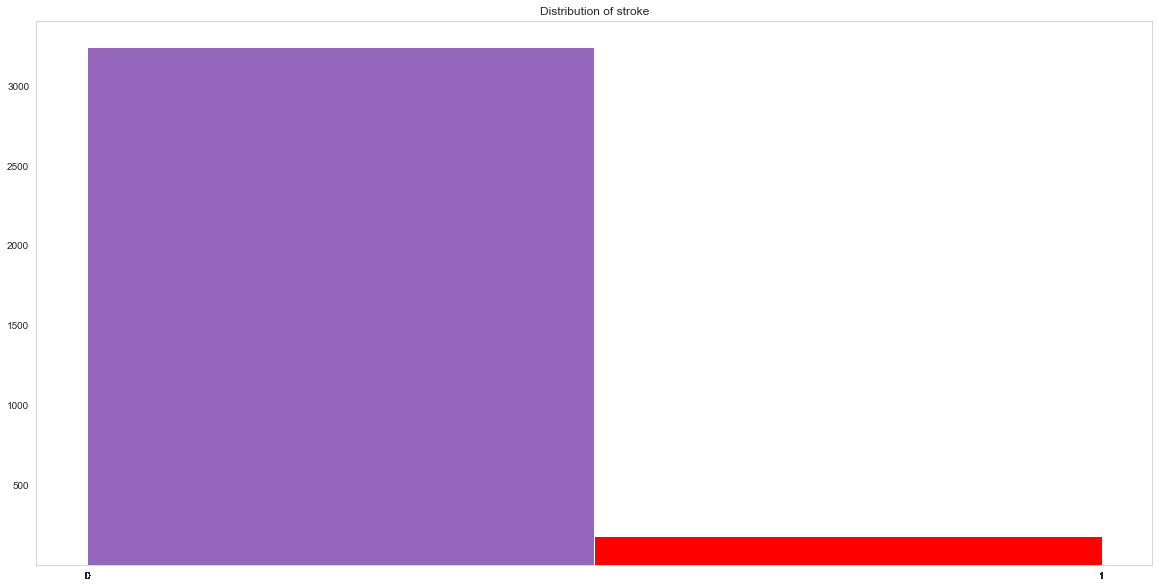

In [45]:
hist_gen(df,'stroke', ['tab:purple', 'r', 'g', 'y','b', 'c', 'm', 'tab:pink', 'tab:orange', 'tab:grey'], 2)

Text(0.5, 1.0, 'Distribution of BMI')

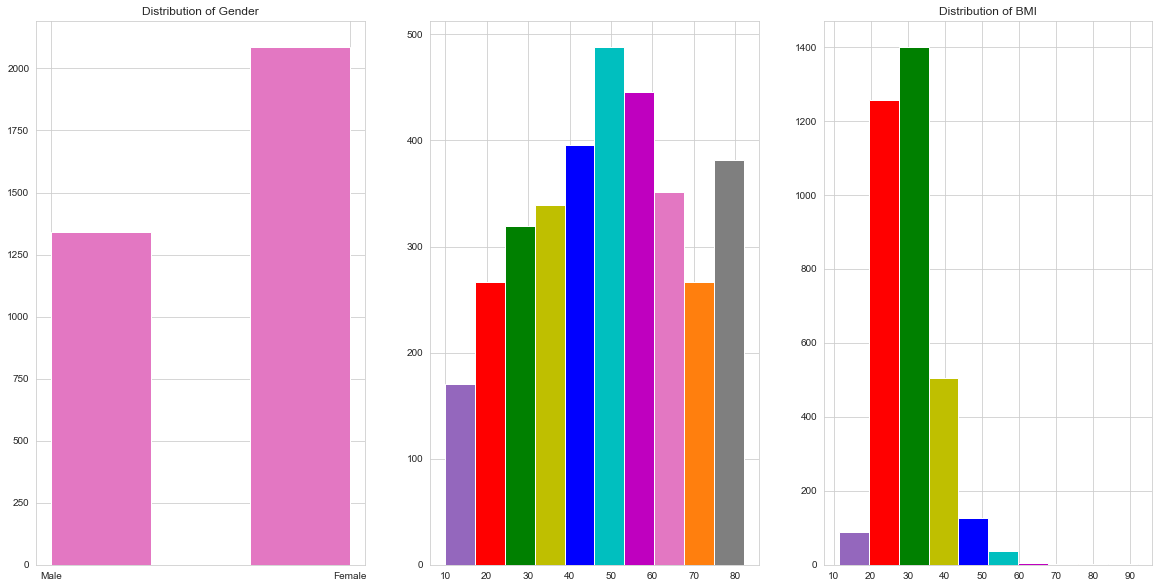

In [7]:
colours = ['tab:purple', 'r', 'g', 'y','b', 'c', 'm', 'tab:pink', 'tab:orange', 'tab:grey']
plt.figure(figsize=(20,10))
plt.subplot(131)
x = random.randint(0, len(colours))
plt.hist(df['gender'], bins=3, color=colours[x])
plt.title('Distribution of Gender')
plt.subplot(132)
n, bins, patches = plt.hist(df['age'])
for i in range(len(patches)):
    c = colours[i]
    patches[i].set_fc(c)
plt.subplot(133)
n, bins, patches = plt.hist(df['bmi'])
for i in range(len(patches)):
    c = colours[i]
    patches[i].set_fc(c)
plt.title('Distribution of BMI')

### Correlations

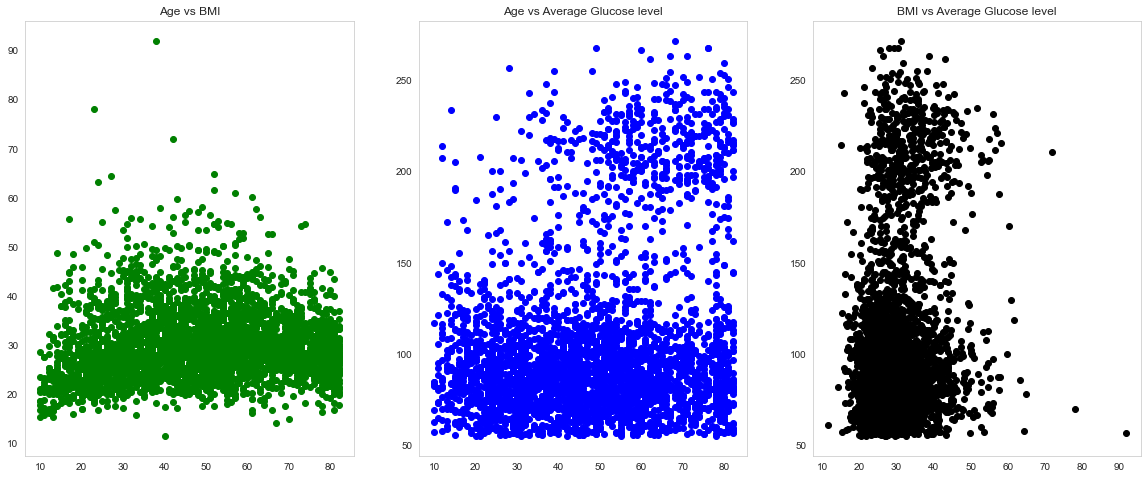

In [60]:
plt.figure(figsize=(20,8))

plt.subplot(131)
plt.title('Age vs BMI')
plt.grid()
plt.scatter(df['age'], df['bmi'], c='g')

plt.subplot(132)
plt.title('Age vs Average Glucose level')
plt.scatter(df['age'], df['avg_glucose_level'], c='b')
plt.grid()

plt.subplot(133)
plt.title('BMI vs Average Glucose level')
plt.scatter(df['bmi'], df['avg_glucose_level'], c='k')
plt.grid()

In [9]:
target = df['stroke']
target = np.array(target)
df['gender'] = pd.factorize(df['gender'])[0]
df['ever_married'] = pd.factorize(df['ever_married'])[0]
df['work_type'] = pd.factorize(df['work_type'])[0]
df['Residence_type'] = pd.factorize(df['Residence_type'])[0]
df['smoking_status'] = pd.factorize(df['smoking_status'])[0]

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [11]:
from sklearn import model_selection
train_data, test_data, train_label, test_label = model_selection.train_test_split(df, 
                                                                                  target,
                                                                                  test_size=0.3,
                                                                                  shuffle=True)

## Comparing 3 of the most commonly used classifiers

### k Nearest Neighbours
This algorithm calculates the distance between each point and determines the k nearest neighbours. When a new point is input for prediction, it finds the nearest k neighbours and classifies it the same as its neighbours.

In [12]:
from sklearn import neighbors
from sklearn import model_selection
knn = neighbors.KNeighborsClassifier()
parameters = {'n_neighbors': [i for i in range(1,33,2)]}
knn = model_selection.GridSearchCV(knn, parameters)
knn = knn.fit(train_data, train_label)
print("The best classifier is:", knn.best_estimator_)
print("Its accuracy is:",knn.best_score_)
print("Its parameters are:",knn.best_params_)

The best classifier is: KNeighborsClassifier(n_neighbors=3)
Its accuracy is: 0.9979157967988865
Its parameters are: {'n_neighbors': 3}


In [13]:
knn = neighbors.KNeighborsClassifier(n_neighbors=list(knn.best_params_.values())[0], weights='uniform')
knn = knn.fit(train_data, train_label)

In [14]:
knn_pred = knn.predict(test_data)

In [15]:
from sklearn.metrics import accuracy_score
knn_accuracy = accuracy_score(test_label, knn_pred)
knn_accuracy *= 100
print('Accuracy of the knn model is %.2f' % knn_accuracy)

Accuracy of the knn model is 99.90


In [16]:
pos, neg = ['True Positives', 'False Positives'], ['False Negatives', 'True Negatives']

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
knn_conf_matrix = confusion_matrix(test_label, knn_pred)

### Random Forest classifier
This is a way to develop many different Decision Trees at once. It allows for boostrapping where a random dataset is constructed from the original data, and duplicates are allowed. The trees are tested and the result of each tree is logged - this is known as aggregation. Bootstrapping and aggregation together are known as bagging.

In [18]:
from sklearn import ensemble
randForest = ensemble.RandomForestClassifier(n_estimators=10)
randForest = randForest.fit(train_data, train_label)

In [19]:
randForest_pred = randForest.predict(test_data)

In [20]:
randForest_accuracy = accuracy_score(test_label, randForest_pred)
randForest_accuracy *= 100
print('Accuracy of the best Decision tree model from the Random Forest is %.2f' % randForest_accuracy)

Accuracy of the best Decision tree model from the Random Forest is 100.00


In [21]:
randForest_conf_matrix = confusion_matrix(test_label, randForest_pred)

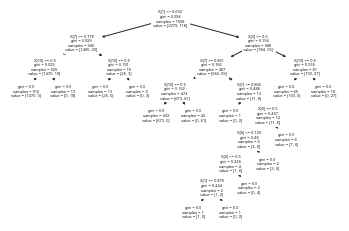

In [24]:
from sklearn import tree
for i in range(len(randForest.estimators_)):
    tree.plot_tree(randForest.estimators_[i])
plt.savefig('DecisionTree')

### Support Vector Classifier 
This model creates a hyperplane that separates both Trues and Falses to either side of the line. The Closest points on both sides are the Support Vector points to which classifying occurs.

In [ ]:
from sklearn import svm
svc = svm.SVC(verbose=True)
svc = svc.fit(train_data, train_label)

In [ ]:
svc_pred = svc.predict(test_data)

In [ ]:
svc_accuracy = accuracy_score(test_label, svc_pred)
svc_accuracy *= 100
print('Accuracy of the best Single Vector Classifier is %.2f' % svc_accuracy)

In [ ]:
svc_conf_matrix = confusion_matrix(test_label, svc_pred)
svc_conf_matrix

#### Confusion Matrices

In [ ]:
print('\nKNN statistic are as follows: ')
for j in range(len(knn_conf_matrix)):
    print(f'\tThe number of {pos[j]} is {knn_conf_matrix[0][j]}')
    print(f'\tThe number of {neg[j]} is {knn_conf_matrix[1][j]}')

print(f'\tSensitivity (TP/TP+FN): {np.round(knn_conf_matrix[0][0]/(knn_conf_matrix[0][0] + knn_conf_matrix[1][0]),4)}')
print(f'\tSpecificity (TN/TN+FP): {knn_conf_matrix[1][1]/(knn_conf_matrix[1][1] + knn_conf_matrix[0][1])}')

print('\nRandom Forest statistic are as follows: ')
for j in range(len(knn_conf_matrix)):
    print(f'\tThe number of {pos[j]} is {randForest_conf_matrix[0][j]}')
    print(f'\tThe number of {neg[j]} is {randForest_conf_matrix[1][j]}')

print(f'\tSensitivity (TP/TP+FN): {randForest_conf_matrix[0][0]/(randForest_conf_matrix[0][0] + randForest_conf_matrix[1][0])}')
print(f'\tSpecificity (TN/TN+FP): {randForest_conf_matrix[1][1]/(randForest_conf_matrix[1][1] + randForest_conf_matrix[0][1])}')

print('\nSVC statistic are as follows: ')
for j in range(len(knn_conf_matrix)):
    print(f'\tThe number of {pos[j]} is {svc_conf_matrix[0][j]}')
    print(f'\tThe number of {neg[j]} is {svc_conf_matrix[1][j]}')

print(f'\tSensitivity (TP/TP+FN): {svc_conf_matrix[0][0]/(svc_conf_matrix[0][0] + svc_conf_matrix[1][0])}')
print(f'\tSpecificity (TN/TN+FP): {svc_conf_matrix[1][1]/(svc_conf_matrix[1][1] + svc_conf_matrix[0][1])}')

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_label,knn_pred, cmap=plt.cm.Reds, normalize='true')
plt.grid()
plt.savefig('KNN Confusion Matrix')